In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from PIL import Image, ImageFile

from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer

#This is to handle corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True

/home/carlos/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/carlos/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/carlos/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/carlos/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: 

In [5]:
#Nesting the directory because of the way the generator works
data_dir = os.path.join('..', '..', 'data', 'scored')
labels_dir = os.path.join('..', '..', 'data', 'scored.csv')
test_dir = os.path.join('..', '..', 'data', 'query')

#This is used later with the batch size
num_train_imgs = len(os.listdir(data_dir))
num_test_imgs = len(os.listdir(os.path.join(test_dir)))

#Just checking that no images are lost on the way
print("number of training images: ", num_train_imgs)
print("number of test images: ", num_test_imgs)

#Getting the indices in order of appearance from the directory and adding png for the generator
scores_df = pd.read_csv(labels_dir)
scores_df.reset_index(drop=True, inplace=True)
scores_df = scores_df.sort_values(by=['Id'])
scores_df['Id'] = scores_df['Id'].astype(str)+'.png'
scores_df

number of training images:  9600
number of test images:  1200


,Id,Actual
9264,1002900.png,2.631728
3920,1003620.png,1.560731
6953,1005208.png,3.137059
7129,1005849.png,3.509851
2528,1006237.png,1.371129
...,...,...
7083,9997019.png,1.561584
8160,9997923.png,3.291464
2776,9998327.png,0.971399
5146,9998462.png,1.890028


In [6]:
#Setting parameters
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [7]:
#scaling values to get intensity between 0 and 1
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [8]:
#Generator for our training data, it's being pulled from the dataframe
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=1)

Found 9600 validated image filenames.


In [10]:
train_X = ([])
train_y = ([])

for i in tqdm(range(len(train_data_gen))):
    (x,y) = train_data_gen[i]
    train_X.append(x)
    train_y.append(y)

    
train_y = np.asarray(train_y).reshape(-1)
train_X = np.asarray(train_X).reshape(-1,150,150,3)

100%|██████████| 9600/9600 [00:57<00:00, 166.74it/s]


In [11]:
def cnn(dropout=0.2, conv_layer_sizes=[16,32], dense_layer_size=128, batch_norm=True, l2_reg=0.001):
    model = Sequential()
    model.add(Conv2D(conv_layer_sizes[0], 3,padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3) ))
    model.add(MaxPooling2D())
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Conv2D(conv_layer_sizes[1], 3,padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3) ))
    model.add(MaxPooling2D())
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Flatten())
    model.add(Dense(dense_layer_size, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='linear'))
    return model

In [12]:
class customCNN(BaseEstimator):
    def __init__(self, epochs=10, batch_size=16, dropout=0.2, 
                   conv_layer_sizes=[16,32], dense_layer_size=128, batch_norm=True, l2_reg=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.conv_layer_sizes = conv_layer_sizes
        self.dense_layer_size = dense_layer_size
        self.batch_norm = batch_norm
        self.l2_reg = l2_reg
    
    def fit(self, train_X, train_y, **kwargs):
        self.build_model()
        self.model.fit(train_X, train_y, epochs=self.epochs, batch_size=self.batch_size)
        
    def predict(self, eval_X):
        return self.model.predict(eval_X)
        
    def set_params(self, epochs=10, batch_size=16, dropout=0.2, 
                   conv_layer_sizes=[16,32], dense_layer_size=128, batch_norm=True, l2_reg=0.001):
        self.epochs = epochs
        self.batch_size = batch_size
        self.dropout = dropout
        self.conv_layer_sizes = conv_layer_sizes
        self.dense_layer_size = dense_layer_size
        self.batch_norm = batch_norm
        self.l2_reg = l2_reg
        
        return self
    
    
    def build_model(self):
        self.model = cnn(dropout=self.dropout, conv_layer_sizes=self.conv_layer_sizes, 
                         dense_layer_size=self.dense_layer_size, batch_norm=self.batch_norm, l2_reg=self.l2_reg)
        self.model.compile(loss='MAE', optimizer='adam', metrics=['MSE'])

In [ ]:
params = {
    'epochs': [25, 40],
    'batch_size': [32],
    'dropout': [0.2, 0.4],
    'l2_reg' : [0.001,0.01],
    'conv_layer_sizes': [[16, 16], [32, 32]],
    'dense_layer_size': [64,128],
    'batch_norm': [True, False]
}

dummy_params = {
    'epochs': [25],
    'batch_size': [32],
    'dropout': [0.2],
    'l2_reg' : [0.01],
    'conv_layer_sizes': [[16, 16]],
    'dense_layer_size': [64],
    'batch_norm': [True]
}

model = customCNN()
search2 = GridSearchCV(estimator=model, 
                      param_grid=params,
                      cv=3,
                      scoring=make_scorer(mean_absolute_error),
                      return_train_score=True, 
                      refit=True, verbose=10, n_jobs=1)
best2 = search2.fit(train_X, train_y)
best2.__dict__

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[CV] batch_norm=True, batch_size=32, conv_layer_sizes=[16, 16], dense_layer_size=64, dropout=0.2, epochs=25, l2_reg=0.001 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [10]:
best2.cv_results_['mean_test_score']

array([1.0230311 , 0.8244972 , 1.04088535, 2.13278749, 1.12533207,
       0.75667899, 1.52458086, 0.96496995, 0.7412967 , 0.80480617,
       0.82634075, 1.09689406, 0.95563994, 0.80768709, 0.83717695,
       0.8262063 , 0.94441724, 0.77647351, 0.7476059 , 0.86528939,
       0.84342522, 0.90307565, 1.64578542, 0.82548854, 0.76111688,
       0.76338376, 0.86565194, 1.11472444, 0.84140423, 0.80801579,
       1.01916089, 0.73594003, 0.62995951, 0.58233069, 0.63355309,
       0.57641669, 0.61117038, 0.60966229, 0.6068596 , 0.58816247,
       0.63577718, 0.5780028 , 0.63618068, 0.5772938 , 0.59623402,
       0.6038881 , 0.60175491, 0.58214421, 0.62971495, 0.62084271,
       0.63084223, 0.58408147, 0.61505957, 0.60105196, 0.61341593,
       0.59698914, 0.63258646, 0.57988153, 0.6328574 , 0.57601805,
       0.59549219, 0.58002142, 0.61278375, 0.5769883 ])

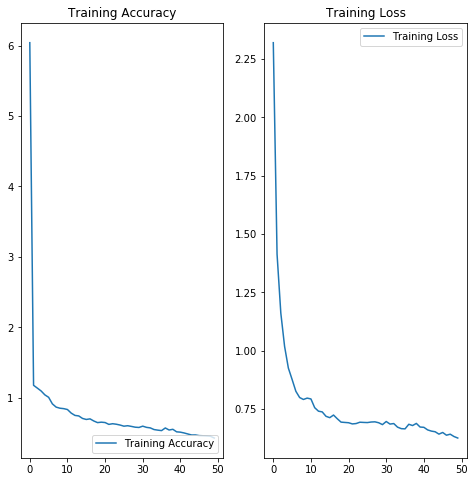

In [29]:
#Pulling some pretty graphs for training

acc = history.history['MSE']

loss=history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()